# Body Results for Uni-modal Approaches

In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf 
import tensorflow_addons as tfa

from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_curve
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, ConvLSTM1D, Bidirectional, Dropout
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, get_feature_names

In [174]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping], batch_size=batch_size, verbose=2)
    return history

In [193]:
def build_CNNLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(conv1d_1)
    dropout_1 = TimeDistributed(Dropout(0.5))(conv1d_2)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(dropout_1)
    conv1d_3 = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='tanh'))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='tanh'))(conv1d_3)
    dropout_2 = TimeDistributed(Dropout(0.5))(conv1d_4)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(dropout_2)
    flatten = TimeDistributed(Flatten())(maxpool_2)
    lstm_1 = Bidirectional(LSTM(300, return_sequences=True))(flatten)
    lstm_2 = Bidirectional(LSTM(300))(lstm_1)
    dense_1 = Dense(256, activation='tanh')(lstm_2)
    dense_2 = Dense(512, activation='tanh')(dense_1)
    output = Dense(units=n_outputs, activation='sigmoid')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

In [198]:
def build_RCNN(n_features, n_length, n_outputs):
   input = Input(shape=(1, n_length, n_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_1)
   conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(maxpool_1)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn_2)
   flatten = Flatten()(maxpool_2)
   dense_1 = Dense(256)(flatten)
   dense_2 = Dense(256)(dense_1)
   output = Dense(units=n_outputs, activation='sigmoid')(dense_2)
   model = Model(inputs=input, outputs=output)
   model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

In [199]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
epochs = 100

### Dataset Features

In [15]:
features = get_feature_names('skeleton')
features.tolist()

['head_x',
 'head_y',
 'head_score',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_score',
 'left_elbow_x',
 'left_elbow_y',
 'left_elbow_score',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_score',
 'right_elbow_x',
 'right_elbow_y',
 'right_elbow_score',
 'left_hand_x',
 'left_hand_y',
 'left_hand_score',
 'right_hand_x',
 'right_hand_y',
 'right_hand_score',
 'left_hip_x',
 'left_hip_y',
 'left_hip_score',
 'right_hip_x',
 'right_hip_y',
 'right_hip_score',
 'left_knee_x',
 'left_knee_y',
 'left_knee_score',
 'right_knee_x',
 'right_knee_y',
 'right_knee_score',
 'left_foot_x',
 'left_foot_y',
 'left_foot_score',
 'right_foot_x',
 'right_foot_y',
 'right_foot_score',
 'pain']

## 1. Binary Classification

In [14]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, body_features, body_outputs = X_train.shape[2], X_train.shape[-1], y_test.shape[1]

(791, 1, 350, 38) (791, 1)
(266, 1, 350, 38) (266, 1)


In [16]:
classes = get_class_names('skeleton', binary=True)
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain    403
Pain       388
dtype: int64

### 1.1 CNN + Bidirectional LSTM

In [209]:
def build_CNNLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(conv1d_1)
    dropout_1 = TimeDistributed(Dropout(0.5))(conv1d_2)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(dropout_1)
    conv1d_3 = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='tanh'))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='tanh'))(conv1d_3)
    dropout_2 = TimeDistributed(Dropout(0.5))(conv1d_4)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(dropout_2)
    flatten = TimeDistributed(Flatten())(maxpool_2)
    lstm_1 = Bidirectional(LSTM(300, return_sequences=True))(flatten)
    lstm_2 = Bidirectional(LSTM(300))(lstm_1)
    dense_1 = Dense(256, activation='tanh')(lstm_2)
    dense_2 = Dense(512, activation='tanh')(dense_1)
    output = Dense(units=n_outputs, activation='sigmoid')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

Epoch 1/100
23/23 - 9s - loss: 0.7227 - accuracy: 0.4993 - auc_191: 0.4764 - precision_191: 0.4896 - recall_191: 0.4029 - f1_score: 0.6598 - val_loss: 0.6962 - val_accuracy: 0.4750 - val_auc_191: 0.5677 - val_precision_191: 0.4750 - val_recall_191: 1.0000 - val_f1_score: 0.6441 - 9s/epoch - 377ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6897 - accuracy: 0.5429 - auc_191: 0.5535 - precision_191: 0.5312 - recall_191: 0.6086 - f1_score: 0.6598 - val_loss: 0.7670 - val_accuracy: 0.5250 - val_auc_191: 0.5454 - val_precision_191: 0.0000e+00 - val_recall_191: 0.0000e+00 - val_f1_score: 0.6441 - 2s/epoch - 76ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6650 - accuracy: 0.6146 - auc_191: 0.6327 - precision_191: 0.6377 - recall_191: 0.5029 - f1_score: 0.6598 - val_loss: 0.6750 - val_accuracy: 0.6125 - val_auc_191: 0.6103 - val_precision_191: 0.6400 - val_recall_191: 0.4211 - val_f1_score: 0.6441 - 2s/epoch - 93ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6377 - accuracy: 0.6428 - auc_191: 0.6921 - precisio

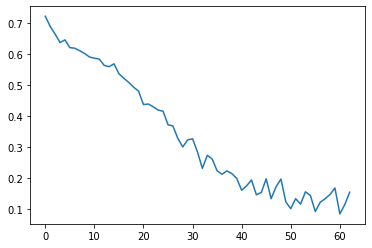

Epoch 1/100
23/23 - 8s - loss: 0.7131 - accuracy: 0.4649 - auc_192: 0.4571 - precision_192: 0.4338 - recall_192: 0.2699 - f1_score: 0.6617 - val_loss: 0.6999 - val_accuracy: 0.4557 - val_auc_192: 0.5000 - val_precision_192: 0.4557 - val_recall_192: 1.0000 - val_f1_score: 0.6261 - 8s/epoch - 353ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6978 - accuracy: 0.4817 - auc_192: 0.4815 - precision_192: 0.4632 - recall_192: 0.3040 - f1_score: 0.6617 - val_loss: 0.7432 - val_accuracy: 0.4557 - val_auc_192: 0.6192 - val_precision_192: 0.4557 - val_recall_192: 1.0000 - val_f1_score: 0.6261 - 2s/epoch - 75ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6831 - accuracy: 0.5744 - auc_192: 0.5928 - precision_192: 0.5617 - recall_192: 0.6335 - f1_score: 0.6617 - val_loss: 0.6610 - val_accuracy: 0.6076 - val_auc_192: 0.6573 - val_precision_192: 0.6923 - val_recall_192: 0.2500 - val_f1_score: 0.6261 - 2s/epoch - 93ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6623 - accuracy: 0.6236 - auc_192: 0.6420 - precision_192: 0

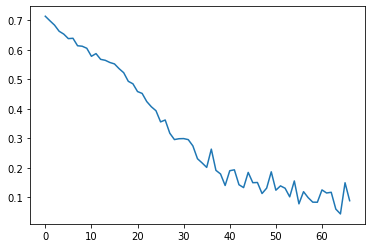

Epoch 1/100
23/23 - 9s - loss: 0.7113 - accuracy: 0.4789 - auc_193: 0.4745 - precision_193: 0.4484 - recall_193: 0.3275 - f1_score: 0.6528 - val_loss: 0.6965 - val_accuracy: 0.4557 - val_auc_193: 0.6024 - val_precision_193: 0.0000e+00 - val_recall_193: 0.0000e+00 - val_f1_score: 0.7049 - 9s/epoch - 383ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6918 - accuracy: 0.5295 - auc_193: 0.5290 - precision_193: 0.5223 - recall_193: 0.3391 - f1_score: 0.6528 - val_loss: 0.7283 - val_accuracy: 0.4557 - val_auc_193: 0.7552 - val_precision_193: 0.0000e+00 - val_recall_193: 0.0000e+00 - val_f1_score: 0.7049 - 2s/epoch - 75ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6740 - accuracy: 0.5913 - auc_193: 0.6094 - precision_193: 0.5971 - recall_193: 0.4812 - f1_score: 0.6528 - val_loss: 0.6364 - val_accuracy: 0.6835 - val_auc_193: 0.7813 - val_precision_193: 0.8214 - val_recall_193: 0.5349 - val_f1_score: 0.7049 - 2s/epoch - 93ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6521 - accuracy: 0.6208 - auc_193: 0.6596 - 

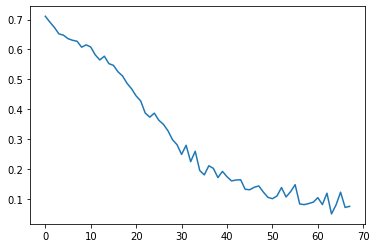

Epoch 1/100
23/23 - 8s - loss: 0.7149 - accuracy: 0.4944 - auc_194: 0.4898 - precision_194: 0.4815 - recall_194: 0.4097 - f1_score: 0.6579 - val_loss: 0.6898 - val_accuracy: 0.4937 - val_auc_194: 0.6545 - val_precision_194: 0.4937 - val_recall_194: 1.0000 - val_f1_score: 0.6610 - 8s/epoch - 355ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6732 - accuracy: 0.5871 - auc_194: 0.6122 - precision_194: 0.5663 - recall_194: 0.6734 - f1_score: 0.6579 - val_loss: 0.6379 - val_accuracy: 0.6456 - val_auc_194: 0.7083 - val_precision_194: 0.6078 - val_recall_194: 0.7949 - val_f1_score: 0.6610 - 2s/epoch - 93ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6569 - accuracy: 0.6278 - auc_194: 0.6562 - precision_194: 0.6193 - recall_194: 0.6246 - f1_score: 0.6579 - val_loss: 0.6487 - val_accuracy: 0.6329 - val_auc_194: 0.6984 - val_precision_194: 0.5962 - val_recall_194: 0.7949 - val_f1_score: 0.6610 - 2s/epoch - 75ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6377 - accuracy: 0.6531 - auc_194: 0.6872 - precision_194: 0

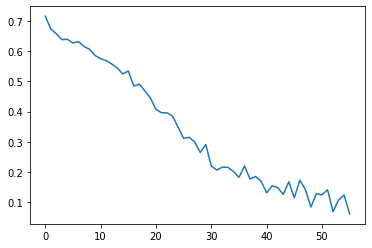

Epoch 1/100
23/23 - 9s - loss: 0.7241 - accuracy: 0.5070 - auc_195: 0.5015 - precision_195: 0.4833 - recall_195: 0.3382 - f1_score: 0.6502 - val_loss: 0.6967 - val_accuracy: 0.4304 - val_auc_195: 0.5908 - val_precision_195: 0.0000e+00 - val_recall_195: 0.0000e+00 - val_f1_score: 0.7258 - 9s/epoch - 377ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6887 - accuracy: 0.5393 - auc_195: 0.5682 - precision_195: 0.5299 - recall_195: 0.3878 - f1_score: 0.6502 - val_loss: 0.6761 - val_accuracy: 0.5949 - val_auc_195: 0.6353 - val_precision_195: 0.6757 - val_recall_195: 0.5556 - val_f1_score: 0.7258 - 2s/epoch - 93ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6581 - accuracy: 0.6124 - auc_195: 0.6541 - precision_195: 0.6218 - recall_195: 0.4985 - f1_score: 0.6502 - val_loss: 0.6527 - val_accuracy: 0.6456 - val_auc_195: 0.6471 - val_precision_195: 0.6667 - val_recall_195: 0.7556 - val_f1_score: 0.7258 - 2s/epoch - 92ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6402 - accuracy: 0.6376 - auc_195: 0.6879 - precisio

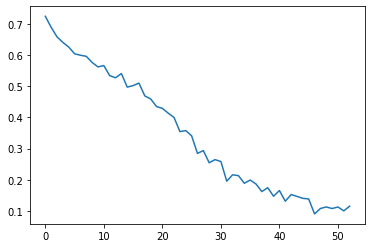

Epoch 1/100
23/23 - 8s - loss: 0.7120 - accuracy: 0.5197 - auc_196: 0.5221 - precision_196: 0.5034 - recall_196: 0.4360 - f1_score: 0.6515 - val_loss: 0.7341 - val_accuracy: 0.4557 - val_auc_196: 0.6195 - val_precision_196: 1.0000 - val_recall_196: 0.0227 - val_f1_score: 0.7154 - 8s/epoch - 352ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6680 - accuracy: 0.6152 - auc_196: 0.6321 - precision_196: 0.6259 - recall_196: 0.5058 - f1_score: 0.6515 - val_loss: 0.6608 - val_accuracy: 0.6076 - val_auc_196: 0.6792 - val_precision_196: 0.6857 - val_recall_196: 0.5455 - val_f1_score: 0.7154 - 2s/epoch - 95ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6551 - accuracy: 0.6362 - auc_196: 0.6601 - precision_196: 0.6358 - recall_196: 0.5785 - f1_score: 0.6515 - val_loss: 0.6474 - val_accuracy: 0.6203 - val_auc_196: 0.7127 - val_precision_196: 0.7500 - val_recall_196: 0.4773 - val_f1_score: 0.7154 - 2s/epoch - 94ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6354 - accuracy: 0.6433 - auc_196: 0.6876 - precision_196: 0

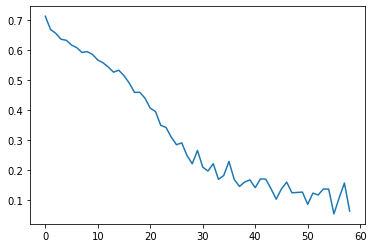

Epoch 1/100
23/23 - 9s - loss: 0.7187 - accuracy: 0.4663 - auc_197: 0.4656 - precision_197: 0.4661 - recall_197: 0.4426 - f1_score: 0.6679 - val_loss: 0.6711 - val_accuracy: 0.6076 - val_auc_197: 0.6616 - val_precision_197: 0.0000e+00 - val_recall_197: 0.0000e+00 - val_f1_score: 0.5636 - 9s/epoch - 379ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6986 - accuracy: 0.5112 - auc_197: 0.5018 - precision_197: 0.5110 - recall_197: 0.5854 - f1_score: 0.6679 - val_loss: 0.6962 - val_accuracy: 0.3924 - val_auc_197: 0.7107 - val_precision_197: 0.3924 - val_recall_197: 1.0000 - val_f1_score: 0.5636 - 2s/epoch - 76ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6863 - accuracy: 0.5548 - auc_197: 0.5681 - precision_197: 0.5463 - recall_197: 0.6611 - f1_score: 0.6679 - val_loss: 0.7433 - val_accuracy: 0.5443 - val_auc_197: 0.6935 - val_precision_197: 0.4545 - val_recall_197: 0.8065 - val_f1_score: 0.5636 - 2s/epoch - 76ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6547 - accuracy: 0.6138 - auc_197: 0.6623 - precisio

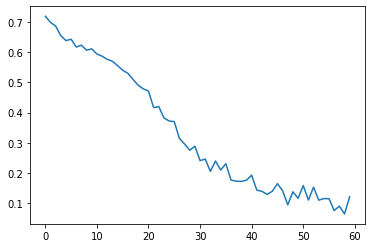

Epoch 1/100
23/23 - 8s - loss: 0.7188 - accuracy: 0.5028 - auc_198: 0.4846 - precision_198: 0.4939 - recall_198: 0.4657 - f1_score: 0.6591 - val_loss: 0.7020 - val_accuracy: 0.5190 - val_auc_198: 0.7015 - val_precision_198: 0.0000e+00 - val_recall_198: 0.0000e+00 - val_f1_score: 0.6496 - 8s/epoch - 353ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6856 - accuracy: 0.5632 - auc_198: 0.5647 - precision_198: 0.5830 - recall_198: 0.3914 - f1_score: 0.6591 - val_loss: 0.7199 - val_accuracy: 0.4937 - val_auc_198: 0.7468 - val_precision_198: 0.4868 - val_recall_198: 0.9737 - val_f1_score: 0.6496 - 2s/epoch - 76ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6694 - accuracy: 0.6194 - auc_198: 0.6327 - precision_198: 0.6152 - recall_198: 0.6029 - f1_score: 0.6591 - val_loss: 0.6180 - val_accuracy: 0.7089 - val_auc_198: 0.7410 - val_precision_198: 0.7027 - val_recall_198: 0.6842 - val_f1_score: 0.6496 - 2s/epoch - 94ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6485 - accuracy: 0.6404 - auc_198: 0.6710 - precisio

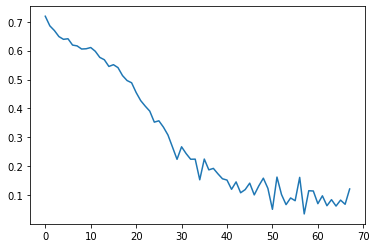

Epoch 1/100
23/23 - 8s - loss: 0.7053 - accuracy: 0.5070 - auc_199: 0.5197 - precision_199: 0.4887 - recall_199: 0.4419 - f1_score: 0.6515 - val_loss: 0.7426 - val_accuracy: 0.4430 - val_auc_199: 0.5672 - val_precision_199: 0.0000e+00 - val_recall_199: 0.0000e+00 - val_f1_score: 0.7154 - 8s/epoch - 353ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6985 - accuracy: 0.5098 - auc_199: 0.4888 - precision_199: 0.4828 - recall_199: 0.2035 - f1_score: 0.6515 - val_loss: 0.7142 - val_accuracy: 0.4430 - val_auc_199: 0.6669 - val_precision_199: 0.0000e+00 - val_recall_199: 0.0000e+00 - val_f1_score: 0.7154 - 2s/epoch - 95ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6821 - accuracy: 0.5801 - auc_199: 0.5891 - precision_199: 0.5812 - recall_199: 0.4680 - f1_score: 0.6515 - val_loss: 0.6491 - val_accuracy: 0.6456 - val_auc_199: 0.6698 - val_precision_199: 0.6818 - val_recall_199: 0.6818 - val_f1_score: 0.7154 - 2s/epoch - 94ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6524 - accuracy: 0.6461 - auc_199: 0.6617 - 

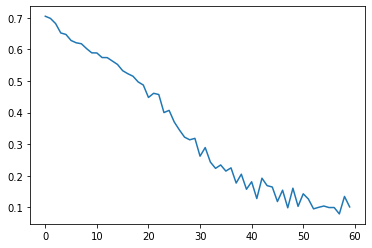

Epoch 1/100
23/23 - 8s - loss: 0.7300 - accuracy: 0.4930 - auc_200: 0.4743 - precision_200: 0.4960 - recall_200: 0.5196 - f1_score: 0.6692 - val_loss: 0.7097 - val_accuracy: 0.3797 - val_auc_200: 0.6558 - val_precision_200: 0.3797 - val_recall_200: 1.0000 - val_f1_score: 0.5505 - 8s/epoch - 369ms/step
Epoch 2/100
23/23 - 2s - loss: 0.6860 - accuracy: 0.5520 - auc_200: 0.5743 - precision_200: 0.5491 - recall_200: 0.6089 - f1_score: 0.6692 - val_loss: 0.6142 - val_accuracy: 0.6962 - val_auc_200: 0.7221 - val_precision_200: 0.6250 - val_recall_200: 0.5000 - val_f1_score: 0.5505 - 2s/epoch - 93ms/step
Epoch 3/100
23/23 - 2s - loss: 0.6535 - accuracy: 0.6278 - auc_200: 0.6613 - precision_200: 0.6380 - recall_200: 0.6006 - f1_score: 0.6692 - val_loss: 0.5999 - val_accuracy: 0.6962 - val_auc_200: 0.7782 - val_precision_200: 0.6667 - val_recall_200: 0.4000 - val_f1_score: 0.5505 - 2s/epoch - 92ms/step
Epoch 4/100
23/23 - 2s - loss: 0.6404 - accuracy: 0.6362 - auc_200: 0.6885 - precision_200: 0

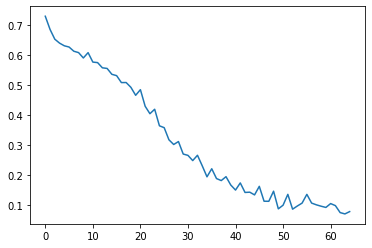

In [219]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
body_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'body_cnnlstm_binary.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    body_cnnlstm = build_CNNLSTM(body_features, n_length, body_outputs)
    history = train(body_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=64)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        body_cnnlstm.save(body_cnnlstm_model_path)

In [220]:
cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
cnnlstm_train_results

{'Accuracy': 0.9613669157028198,
 'ROC/AUC': 0.9936180830001831,
 'Precision': 0.9604418814182282,
 'Recall': 0.9610065340995788,
 'F1-score': 0.6581543684005737}

In [221]:
cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
cnnlstm_val_results

{'Accuracy': 0.6865189850330353,
 'ROC/AUC': 0.7357219457626343,
 'Precision': 0.6499293506145477,
 'Recall': 0.7842544734477996,
 'F1-score': 0.6556458175182343}

In [222]:
body_cnnlstm = tf.keras.models.load_model(body_cnnlstm_model_path)
y_pred = body_cnnlstm.predict(X_test)
_, acc, auc, precision, recall, f1 = body_cnnlstm.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 46.62% 
ROC/AUC: 0.68 
Precision: 0.93 
Recall: 0.41 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

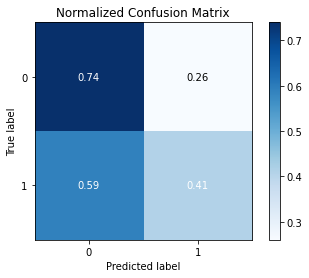

In [218]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

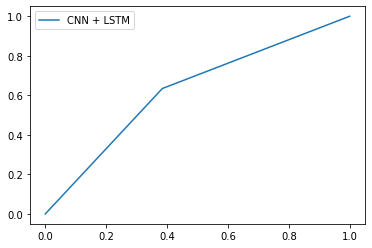

In [192]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + LSTM')
plt.legend()
plt.show()

### 1.2 RCNN

In [111]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []

body_rcnn_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'body_rcnn.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    body_rcnn = build_RCNN(body_features, n_length, body_outputs)
    history = train(body_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        body_rcnn.save(body_rcnn_model_path)

NameError: name 'build_RCNN' is not defined

In [24]:
body_rcnn_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
body_rcnn_train_results

{'Accuracy': 0.9067760586738587,
 'ROC/AUC': 0.9848008394241333,
 'Precision': 0.9134167075157166,
 'Recall': 0.8985581994056702,
 'F1-score': 0.8640071153640747}

In [25]:
body_rcnn_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
body_rcnn_val_results

{'Accuracy': 0.47278878688812254,
 'ROC/AUC': 0.718096387386322,
 'Precision': 0.48057926893234254,
 'Recall': 0.4677493810653687,
 'F1-score': 0.26292245388031005}

## 2. Multi-class Classification

### About the data

In [ ]:
X_train, X_test, y_train, y_test = load_dataset('skeleton')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, body_features, body_outputs = X_train.shape[2], X_train.shape[-1], y_test.shape[1]

In [ ]:
classes = get_class_names('skeleton')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

### 2.1 CNN + Bidirectional LSTM

In [ ]:
def build_CNNLSTM(n_features, n_length, n_outputs):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='tanh'))(conv1d_1)
    dropout_1 = TimeDistributed(Dropout(0.5))(conv1d_2)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(dropout_1)
    conv1d_3 = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='tanh'))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='tanh'))(conv1d_3)
    dropout_2 = TimeDistributed(Dropout(0.5))(conv1d_4)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(dropout_2)
    flatten = TimeDistributed(Flatten())(maxpool_2)
    lstm_1 = Bidirectional(LSTM(300, return_sequences=True))(flatten)
    lstm_2 = Bidirectional(LSTM(300))(lstm_1)
    dense_1 = Dense(256, activation='tanh')(lstm_2)
    dense_2 = Dense(512, activation='tanh')(dense_1)
    output = Dense(units=n_outputs, activation='sigmoid')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

In [ ]:
acc = []
acc_val = []
auc = []
auc_val = []
precision = []
precision_val = []
recall = []
recall_val = []
f1 = []
f1_val = []
body_cnnlstm_model_path = Path(os.path.abspath('')).parent / 'models' / 'saved' / 'body_cnnlstm_multi.h5'
val_accuracy = 0.0

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    body_cnnlstm = build_CNNLSTM(body_features, n_length, body_outputs)
    history = train(body_cnnlstm, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=32)
    plt.plot(history.history['loss'])
    plt.show()
    acc.append(history.history['accuracy'][-1])
    acc_val.append(history.history['val_accuracy'][-1])
    f1.append(history.history['f1_score'][-1])
    f1_val.append(history.history['val_f1_score'][-1])
    save_model = False
    for key in history.history.keys():
        if 'auc' in key and not 'val' in key:
            auc.append(history.history[key][-1])
        elif 'auc' in key and 'val' in key:
            auc_val.append(history.history[key][-1])
            if history.history[key][-1] > val_accuracy:
                val_accuracy = history.history[key][-1]
                save_model = True
        if 'precision' in key and not 'val' in key:
            precision.append(history.history[key][-1])
        elif 'precision' in key and 'val' in key:
            precision_val.append(history.history[key][-1])
        if 'recall' in key and not 'val' in key:
            recall.append(history.history[key][-1])
        elif 'recall' in key and 'val' in key:
            recall_val.append(history.history[key][-1])
    if save_model:
        body_cnnlstm.save(body_cnnlstm_model_path)

In [ ]:
cnnlstm_train_results = {'Accuracy': np.average(acc), 'ROC/AUC': np.average(auc), 'Precision': np.average(precision), 'Recall': np.average(recall), 'F1-score': np.average(f1)}
cnnlstm_train_results

In [ ]:
cnnlstm_val_results = {'Accuracy': np.average(acc_val), 'ROC/AUC': np.average(auc_val), 'Precision': np.average(precision_val), 'Recall': np.average(recall_val), 'F1-score': np.average(f1_val)}
cnnlstm_val_results

In [ ]:
body_cnnlstm = tf.keras.models.load_model(body_cnnlstm_model_path)
y_pred = body_cnnlstm.predict(X_test)
_, acc, auc, precision, recall, f1 = body_cnnlstm.evaluate(X_test, y_test, verbose=0)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True)

In [ ]:
skplt.metrics.plot_roc_curve(y_test.argmax(axis=1), y_pred)

### 2.2 RCNN

In [ ]:
body_rcnn = tf.keras.models.load_model(body_rcnn_model_path)
y_pred = body_rcnn.predict(full_body_X_test)

In [ ]:
_, acc, auc, precision, recall, f1 = body_rcnn.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 18.05% 
Balanced Accuracy: 17.96% 
ROC/AUC: 0.50 
Precision: 0.18 
Recall: 0.16 
F1 score: 0.10


In [ ]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True)

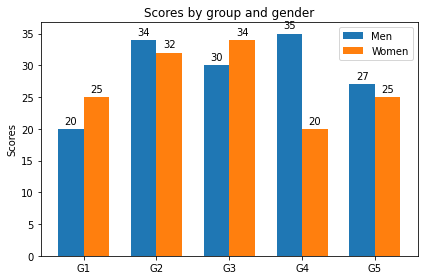

In [ ]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

ax.set_ylabel('Scores') 
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()